In [1]:
import movement_disorder_dl as md

data = md.data.lfp_data.EssentialTremorLFPDataset_Posture()


Parsing data...: 100%|██████████| 8/8 [00:00<00:00, 13.90it/s]


In [2]:
for i in data.holder_label: 
    print(len(i))

854681
790435
1033826
1053399
892514
879848
917717
1274983


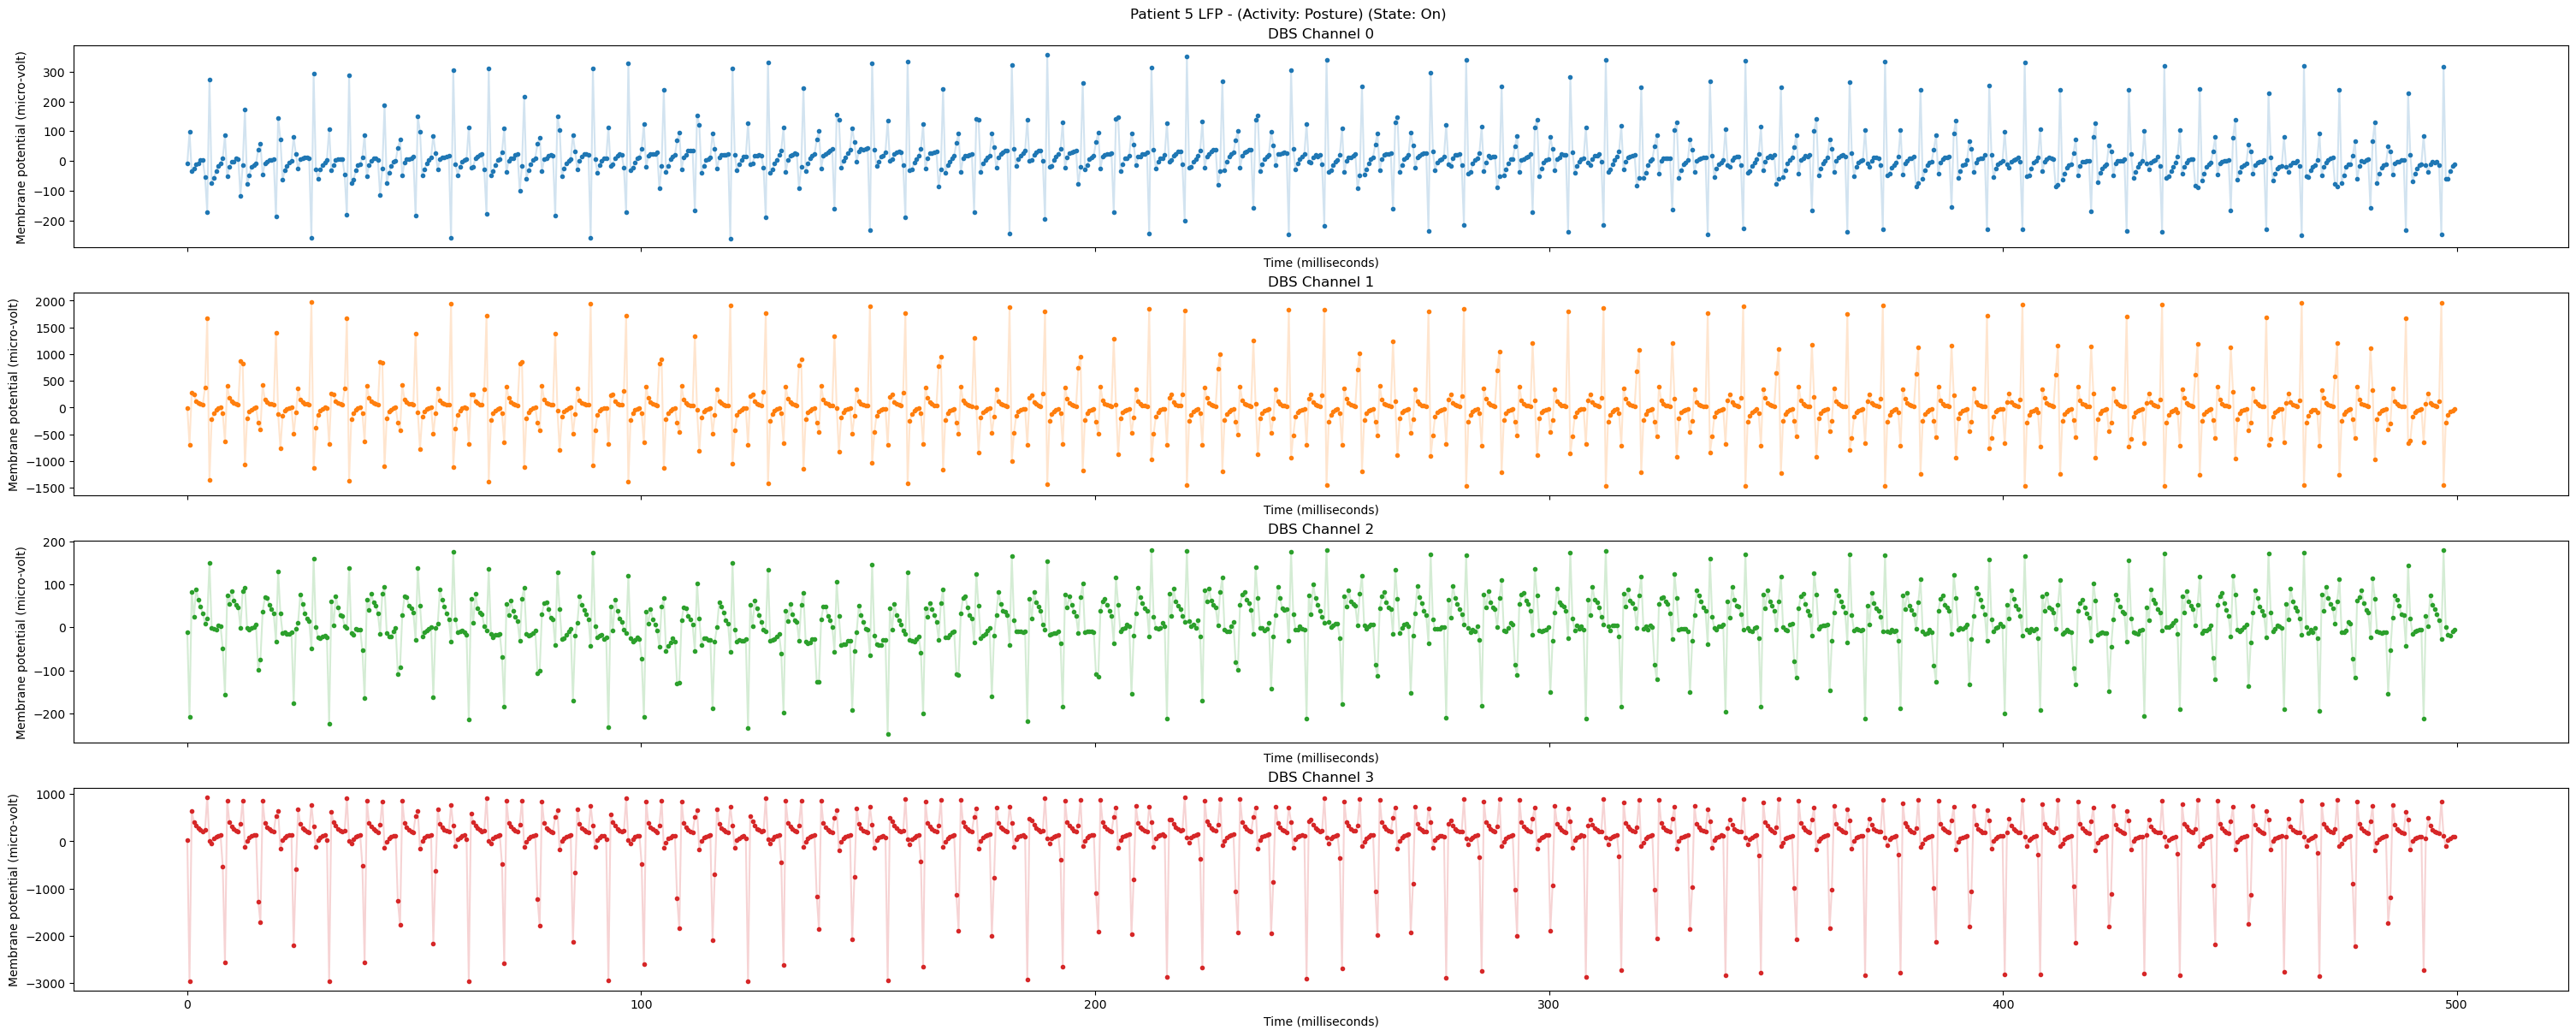

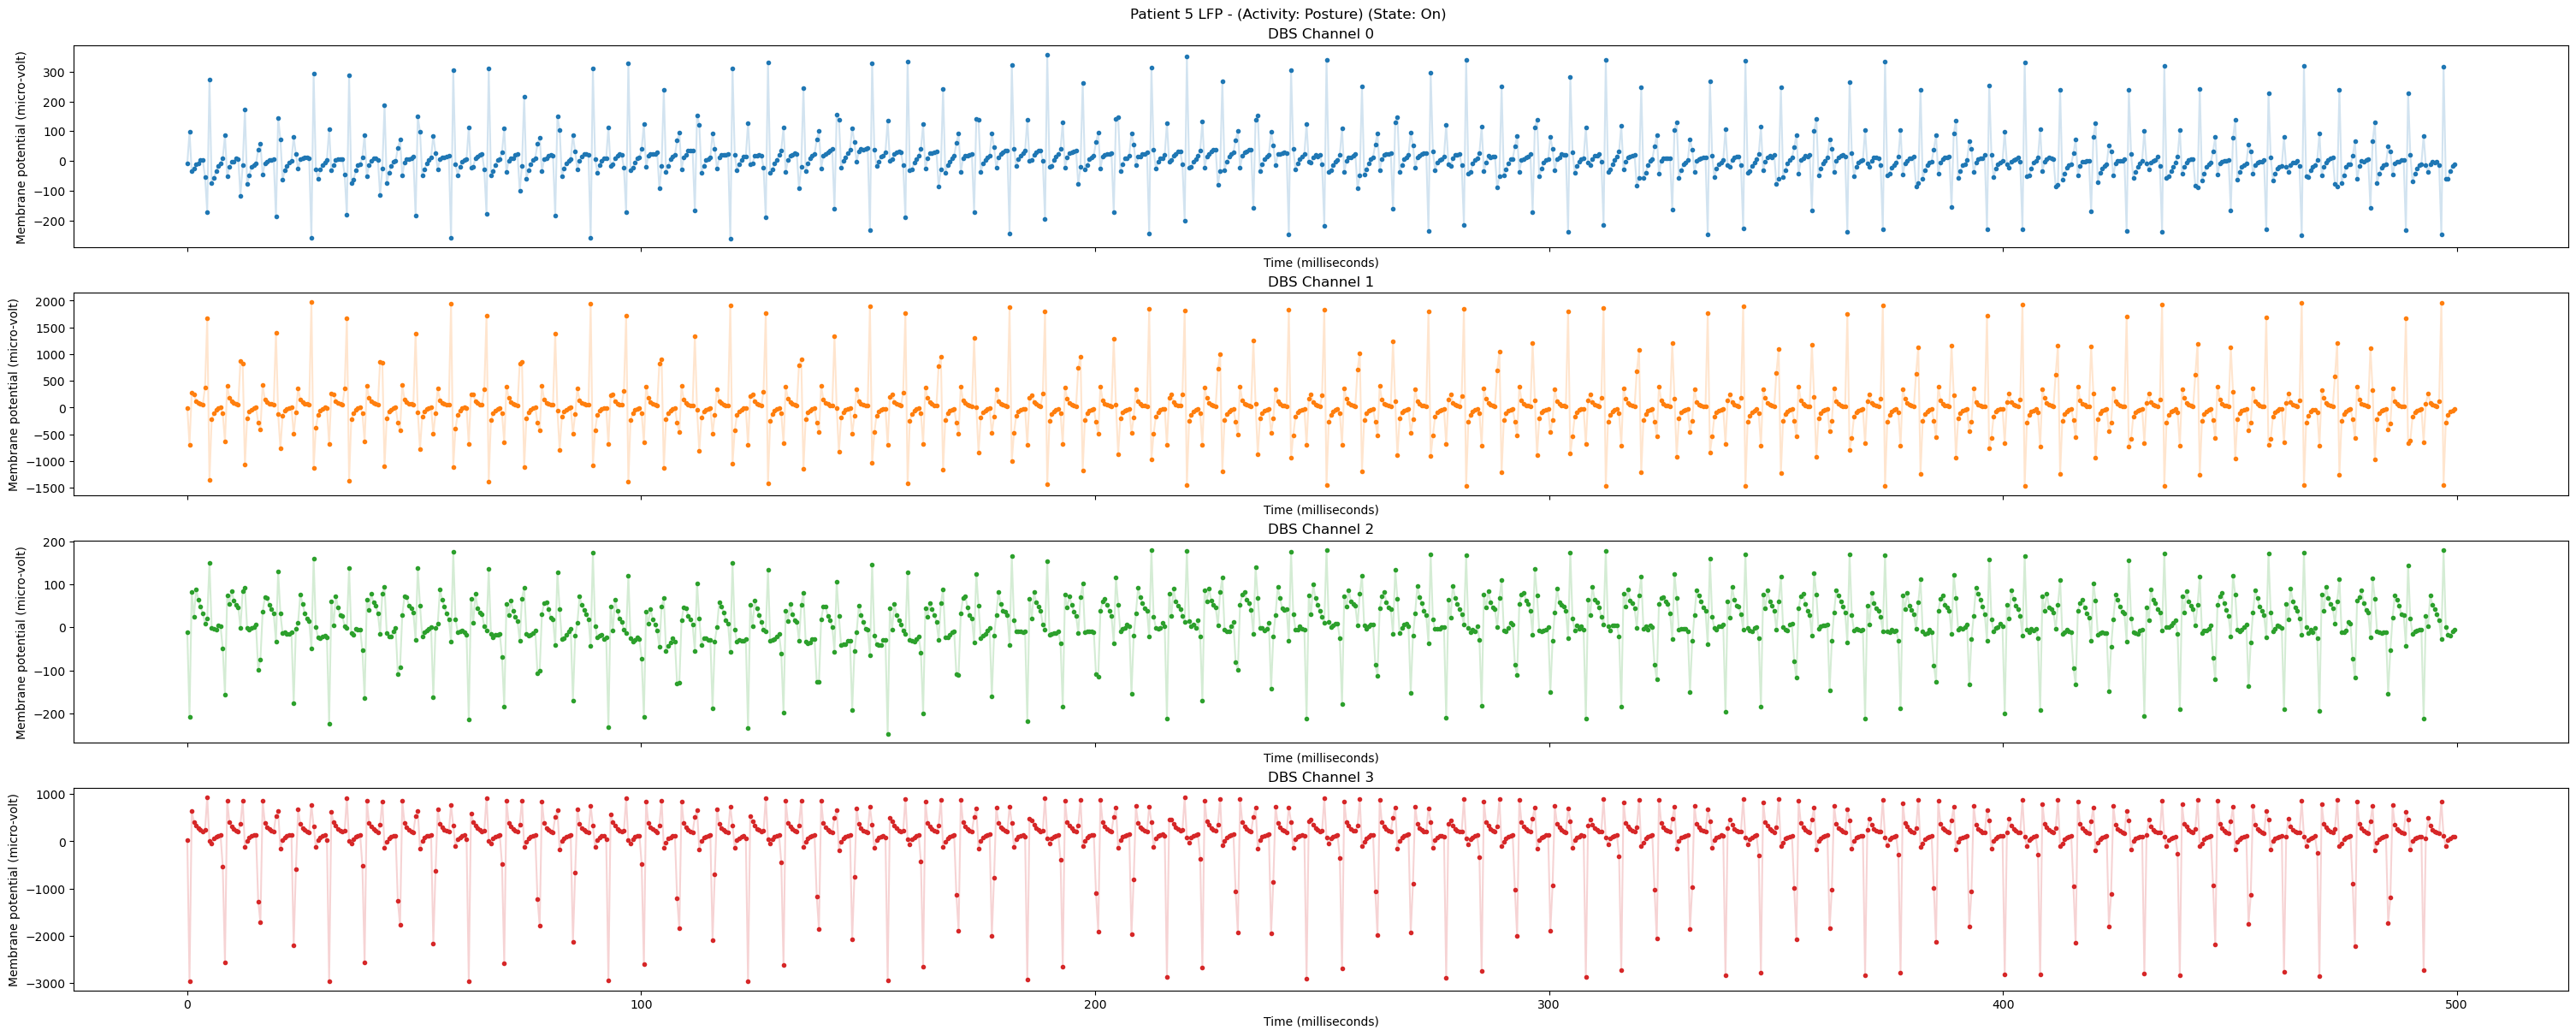

In [3]:
import h5py
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from movement_disorder_dl.plotter.lfp_plotter import plot_lfp

plt.ioff()  

def get_lfp_and_label_of_posture_on(patient_num:int):
    
    filepath = Path(f'../data/essential_tremor/ET{patient_num}/Posture_on.h5')

    with h5py.File(filepath, 'r') as file: 
        lfp_data = file['LFP'][:]
        lfp_label = file['label'][:]
        
    return lfp_data, lfp_label



def plot_lfp_of_patient(patient_num:int, first_n_sec=None):
    
    lfp, label = get_lfp_and_label_of_posture_on(patient_num=patient_num)
    fig = plot_lfp(multi_channel_lfp=lfp, first_n_sec=first_n_sec)
    fig.suptitle(f'Patient {patient_num} LFP - (Activity: Posture) (State: On)', fontsize=12)
    fig.set_layout_engine('constrained')
    
    return fig


fig = plot_lfp_of_patient(patient_num=5)
fig
        

    

(894561,)


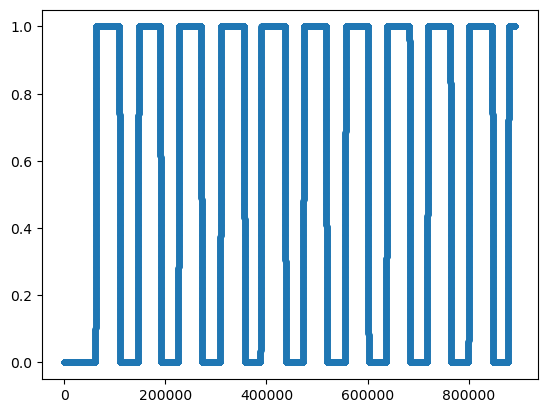

In [4]:
lfp, label =  get_lfp_and_label_of_posture_on(5)

print(label.shape)
temp = np.lib.stride_tricks.sliding_window_view(label, window_shape=2048)
temp = temp.mean(axis=1)

x = range(len(temp))
y = temp
plt.scatter(x, y, marker='.')
plt.show()

892928


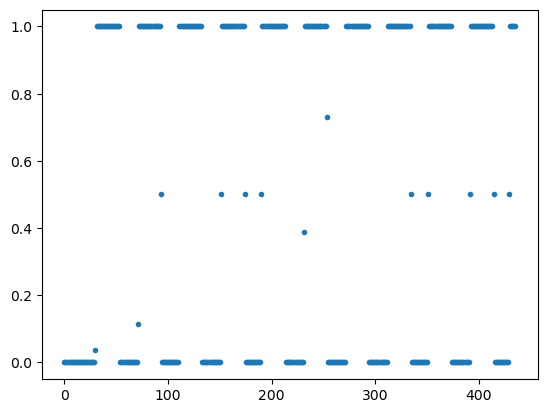

In [5]:
lfp, label =  get_lfp_and_label_of_posture_on(5)

endpoint = len(label) - len(label)%2048
print(endpoint)
label = label[: endpoint]
temp = label.reshape(-1, 2048)
temp = temp.mean(axis=1)

x = range(len(temp))
y = temp
plt.scatter(x, y, marker='.')
plt.show()

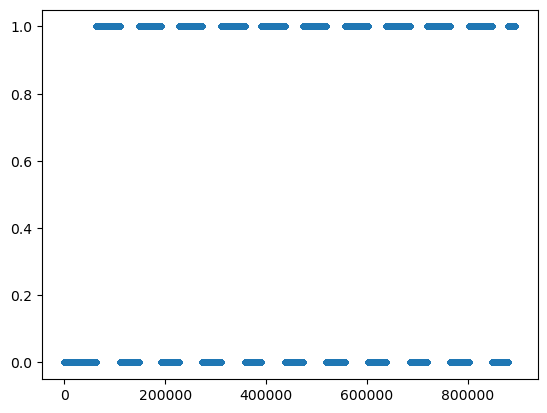

In [6]:
lfp, label =  get_lfp_and_label_of_posture_on(5)


x, y = range(len(label)), label
plt.scatter(x, y, marker='.')
plt.show()

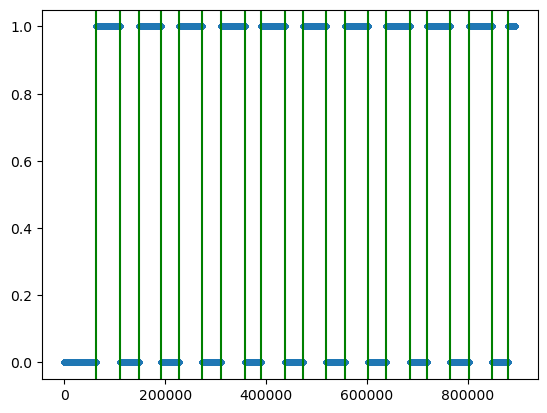

true segments: [(np.int64(63412), np.int64(110591)), (np.int64(147222), np.int64(191487)), (np.int64(227328), np.int64(272383)), (np.int64(310272), np.int64(357375)), (np.int64(390144), np.int64(438271)), (np.int64(474339), np.int64(519638)), (np.int64(557056), np.int64(602111)), (np.int64(638976), np.int64(685055)), (np.int64(719872), np.int64(765951)), (np.int64(801792), np.int64(848895))]


In [7]:
# TODO: Plot differences between True vs False

def find_idx_of_switches(labels:list) -> list:
    idx_switch = np.argwhere(np.diff(labels) != 0).squeeze()
    return idx_switch

def find_true_false_segments(labels, debug:bool=None) -> tuple:
    """Given labels, return the idx ranges of True-/False-segments."""
    if debug is None:
        debug = False
        
    true_segments = []
    false_segments = []

    segments = np.lib.stride_tricks.sliding_window_view(idx_switch, window_shape=2)
    segments = np.concat( [[[-1, segments[0][0]]], segments], axis=0 )  # Add the very first segment that doesn't have the initial switch to bookend - Negative 1 because of later offset

    
    for beginning, end in segments: 
        beginning += 1  # Because of how np.diff works, the index marks the element before the start of segment
        
        if debug: 
            print(label[beginning], label[end])
            print(np.mean(label[beginning: end+1], dtype=int))
        
        assert (label[beginning] == label[end]) & (label[end] == np.mean(label[beginning:end+1], dtype=int))
        
        match bool(label[beginning]):  # np.bool vs regular Python bool
            case True:
                true_segments.append( (beginning, end) )
            case False:
                false_segments.append( (beginning, end) )
            case _:
                raise ValueError(f'Received {label[beginning]} of type {type(label[beginning])}')
                
    return (true_segments, false_segments)


# Method 1 - Finding Trues and Falses separatly
# lfp, label =  get_lfp_and_label_of_posture_on(5)
# idx_true = np.argwhere(label==True).squeeze()
# idx_false = np.argwhere(label==False).squeeze()

# edges_true = np.argwhere(np.diff(idx_true) != 1)
# edges_false = np.argwhere(np.diff(idx_false) != 1)
# print( edges_true )
# print(edges_false)


# plt.scatter(range(len(label)), label, marker='.')

# idx_ref, edge_ref, color =idx_true, edges_true, 'red'
# for x in edge_ref:
#     print(x, label[idx_ref[x]], label[idx_ref[x]+1])    
#     x = idx_ref[x]
#     plt.axvline(x=x, c=color)
    
# idx_ref, edge_ref, color = idx_false, edges_false, 'green'
# for x in edge_ref:
#     print(x, label[idx_ref[x]], label[idx_ref[x]+1])    
#     x = idx_ref[x]
#     plt.axvline(x=x, c=color)


## Method 2 - Finding where things switches
lfp, label =  get_lfp_and_label_of_posture_on(5)
idx_switch = find_idx_of_switches(labels=label)

plt.scatter(range(len(label)), label, marker='.') 

ref, color = idx_switch, 'green'
for x in ref:
    # print(x, label[x], label[x+1])
    plt.axvline(x=x, c=color)
    
plt.show()

# Method 3 - Using the switch idx
lfp, label = get_lfp_and_label_of_posture_on(5)
true_seg, false_seg = find_true_false_segments(labels=label)

print(f'true segments: {true_seg}')


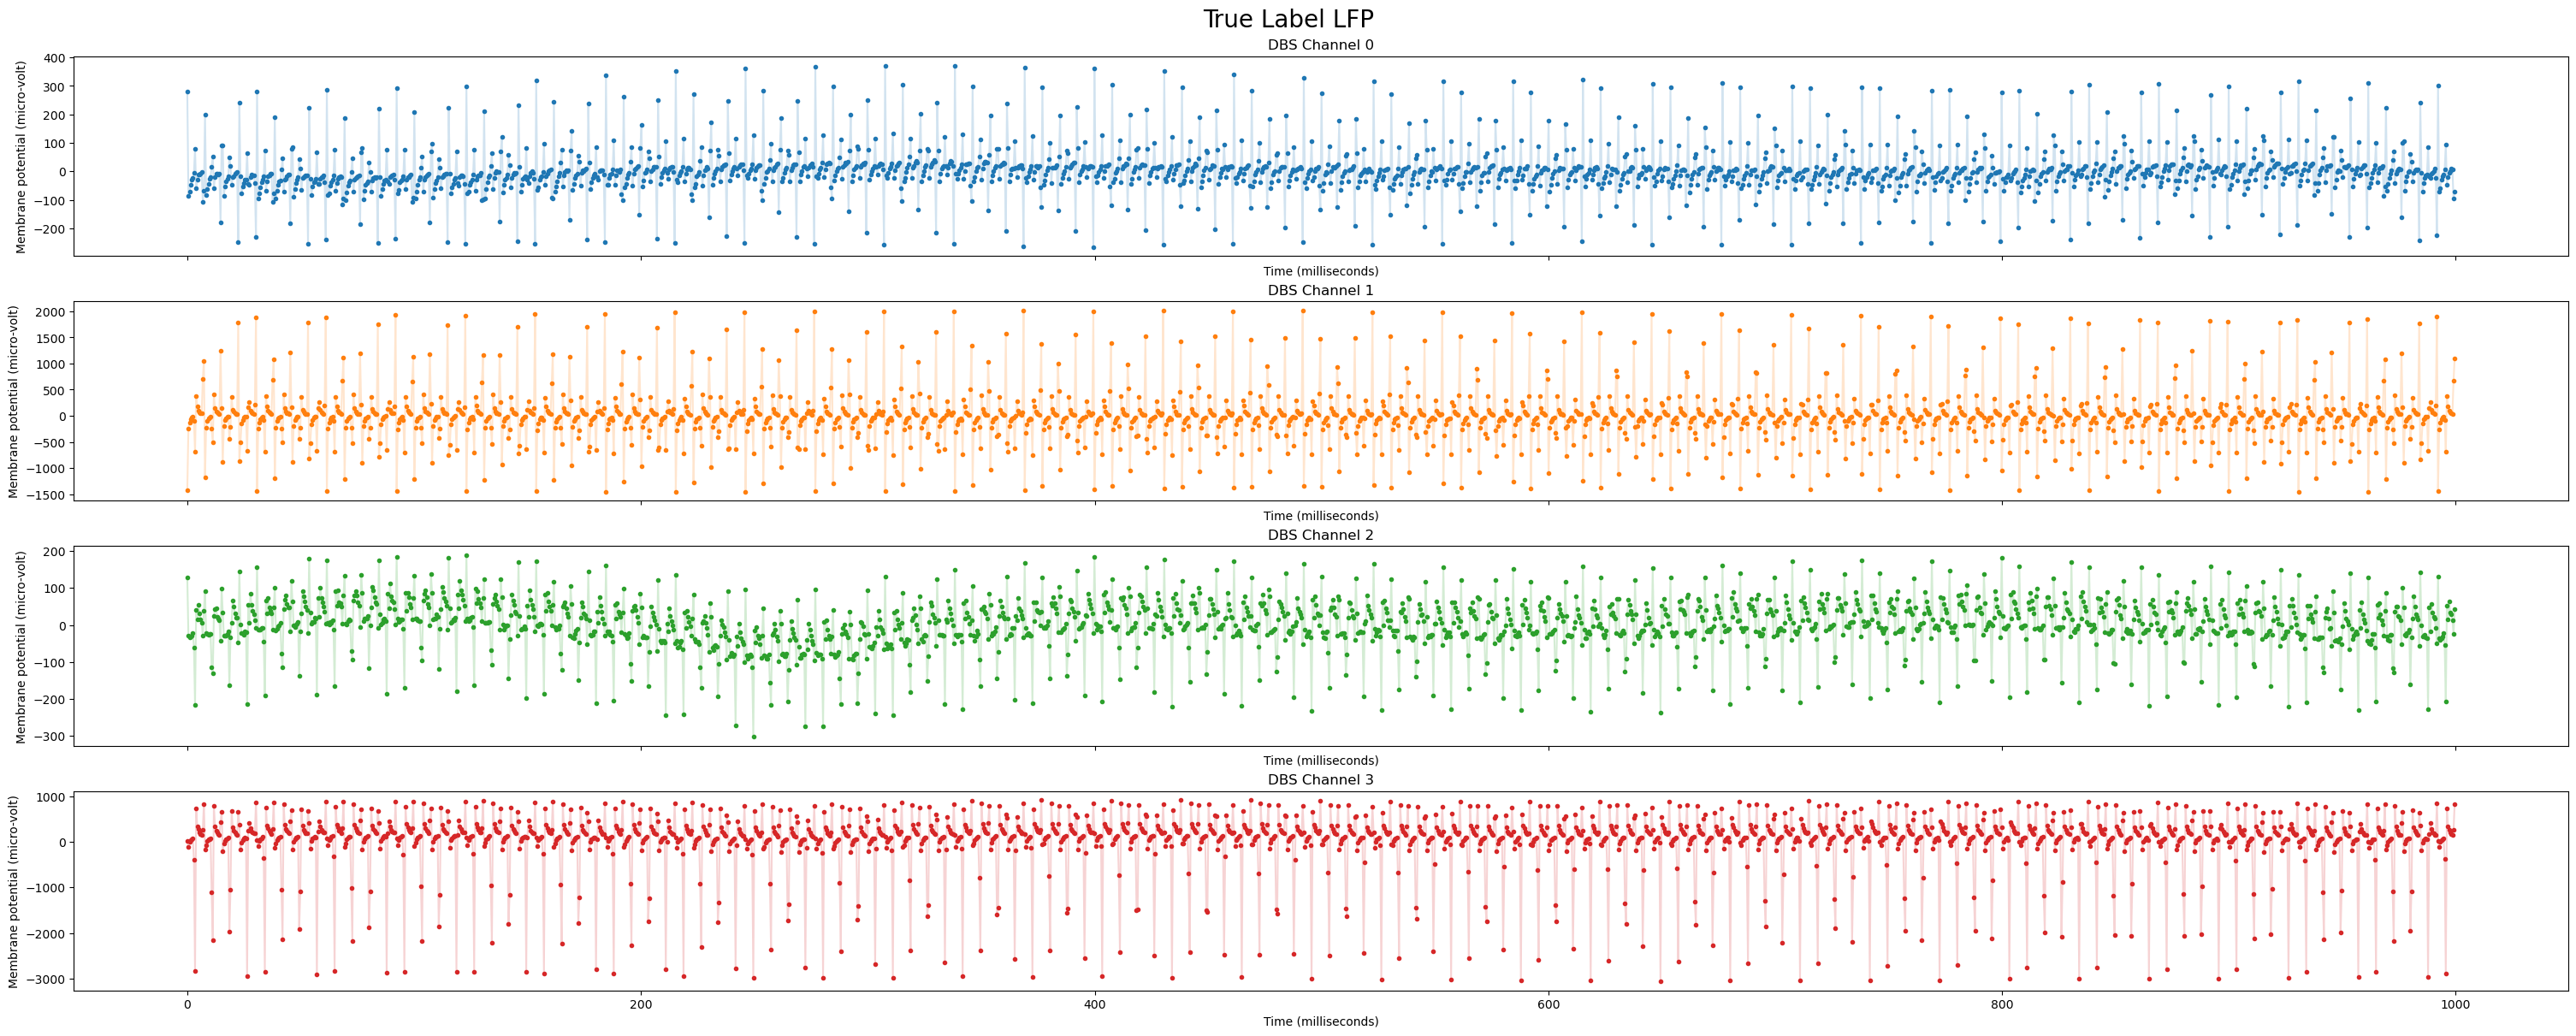

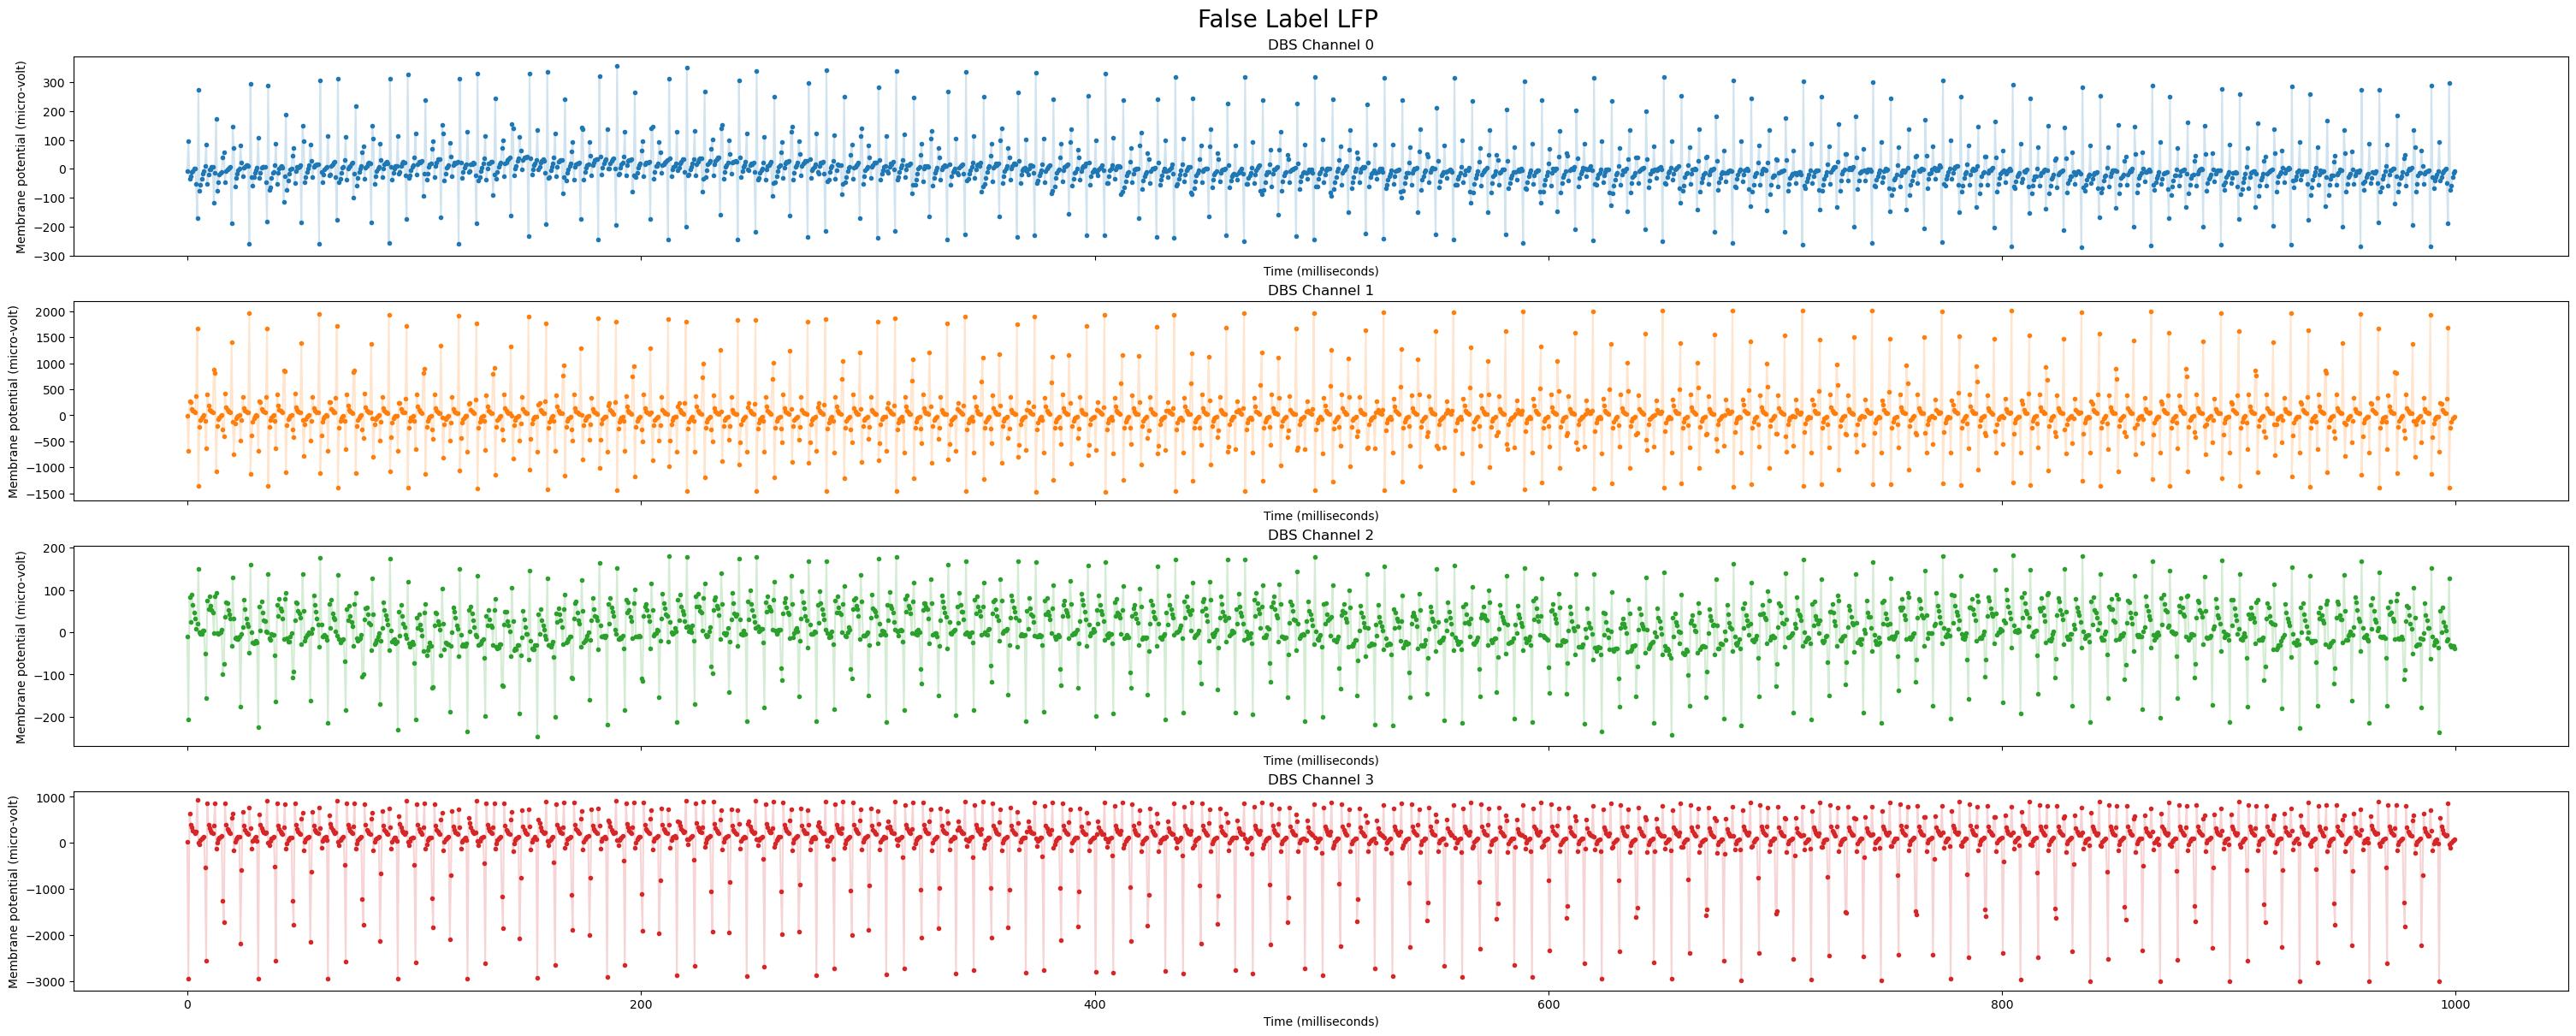

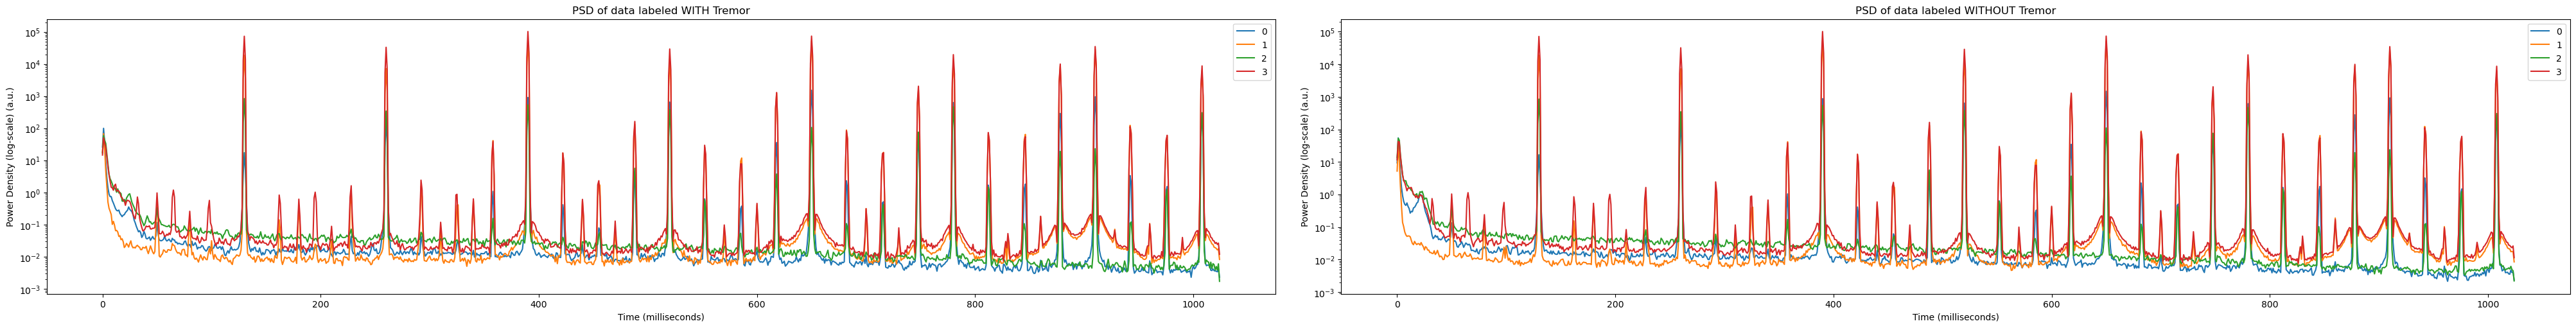

In [8]:
def plot_psd_example(patient_num:int):
    from movement_disorder_dl.spectral.psd import psd_welch_contaldi_2023
    from movement_disorder_dl.plotter.psd_plotter import plot_psd_ax

    lfp, label = get_lfp_and_label_of_posture_on(patient_num=patient_num)
    true_segs, false_segs = find_true_false_segments(labels=label)

    true_seg, false_seg = true_segs[0], false_segs[0]

    true_lfp = lfp[:, true_seg[0]:true_seg[1]]
    false_lfp = lfp[:, false_seg[0]:false_seg[1]]

    nrows, ncols, inches, xyratio = 1, 2, 5, 4
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*inches*xyratio, nrows*inches))

    ax = axs[0]
    for idx, data in enumerate(true_lfp):
        freq, psd = psd_welch_contaldi_2023(data=data, fs=2048)
        plot_psd_ax(psd=psd, ax=ax, title='PSD of data labeled WITH Tremor', label=idx)
        
    ax = axs[1]
    for idx, data in enumerate(false_lfp):
        freq, psd = psd_welch_contaldi_2023(data=data, fs=2048)
        plot_psd_ax(psd=psd, ax=ax, title='PSD of data labeled WITHOUT Tremor', label=idx)

    fig.set_layout_engine('constrained')
    
    return fig


def plot_lfp_example_zoomed_in(patient_num:int):
    from movement_disorder_dl.plotter.lfp_plotter import plot_lfp

    lfp, label = get_lfp_and_label_of_posture_on(patient_num=patient_num)
    true_segs, false_segs = find_true_false_segments(labels=label)

    true_seg, false_seg = true_segs[0], false_segs[0]

    true_lfp = lfp[:, true_seg[0]:true_seg[1]]
    false_lfp = lfp[:, false_seg[0]:false_seg[1]]

    fig_true = plot_lfp(multi_channel_lfp=true_lfp, first_n_sec=1)
    fig_true.suptitle(f'True Label LFP', fontsize=20)
    fig_true.set_layout_engine('constrained')

    fig_false = plot_lfp(multi_channel_lfp=false_lfp, first_n_sec=1)
    fig_false.suptitle(f'False Label LFP', fontsize=20)
    fig_false.set_layout_engine('constrained')


    return fig_true, fig_false



## Plotting LFP
lfp_true, lfp_false = plot_lfp_example_zoomed_in(5)
lfp_true.savefig('figures/LFP_of_with_tremor_zoomed_in.svg')
lfp_false.savefig('figures/LFP_of_without_tremor_zoomed_in.svg')



## Plotting the PSD
psd_fig = plot_psd_example(5)
psd_fig.savefig('figures/PSD_of_tremor_and_no_tremor.svg')


In [ ]:
# TODO: Create a table presenting the patient data shapes

from dataclasses import dataclass, asdict
import pandas as pd


@dataclass
class PatientDataInfo:
    patient_num: int
    channel_count: int
    sample_count: int
    recording_length_seconds: float 
    n_non_overlapping: int
    n_overlapping:int
    
holder = []

# Iterate through all the patient datas
for i in range(1, 9):
    sampling_freq = 2048
    
    # Raw data read in
    lfp, label = get_lfp_and_label_of_posture_on(i)
    
    # Data length
    channel_count = lfp.shape[0]
    sample_count = lfp.shape[1]
    recording_length_seconds = sample_count / sampling_freq
    
    # Data augmentation
    n_non_overlapping = int(sample_count // sampling_freq)
    n_overlapping = np.lib.stride_tricks.sliding_window_view(lfp[0], window_shape=2048).shape[0]
    
    patient_data = PatientDataInfo(
        patient_num=i,
        channel_count=channel_count,
        sample_count=sample_count,
        recording_length_seconds=recording_length_seconds,
        n_non_overlapping=n_non_overlapping,
        n_overlapping=n_overlapping,
    )
    

    # Add to holder
    holder.append(asdict(patient_data))
    

# Create dataframe
df = pd.DataFrame(data=holder)
df = 
df.head()


,patient_num,channel_count,sample_count,recording_length_seconds,n_non_overlapping,n_overlapping
0,1,3,856728,418.324219,418,854681
1,2,5,792482,386.954102,386,790435
2,3,4,1035873,505.797363,505,1033826
3,4,6,1055446,515.354492,515,1053399
4,5,4,894561,436.797363,436,892514


In [13]:
html_str = df.to_html()
print(html_str)

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>patient_num</th>
      <th>channel_count</th>
      <th>sample_count</th>
      <th>recording_length_seconds</th>
      <th>n_non_overlapping</th>
      <th>n_overlapping</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1</td>
      <td>3</td>
      <td>856728</td>
      <td>418.324219</td>
      <td>418</td>
      <td>854681</td>
    </tr>
    <tr>
      <th>1</th>
      <td>2</td>
      <td>5</td>
      <td>792482</td>
      <td>386.954102</td>
      <td>386</td>
      <td>790435</td>
    </tr>
    <tr>
      <th>2</th>
      <td>3</td>
      <td>4</td>
      <td>1035873</td>
      <td>505.797363</td>
      <td>505</td>
      <td>1033826</td>
    </tr>
    <tr>
      <th>3</th>
      <td>4</td>
      <td>6</td>
      <td>1055446</td>
      <td>515.354492</td>
      <td>515</td>
      <td>1053399</td>
    </tr>
    <tr>
      <th>4</th>
      <td>5</td>
 

In [12]:
md_str = df.to_markdown()
print(md_str)


|    |   patient_num |   channel_count |     sample_count |   recording_length_seconds |   n_non_overlapping |    n_overlapping |
|---:|--------------:|----------------:|-----------------:|---------------------------:|--------------------:|-----------------:|
|  0 |             1 |               3 | 856728           |                    418.324 |                 418 | 854681           |
|  1 |             2 |               5 | 792482           |                    386.954 |                 386 | 790435           |
|  2 |             3 |               4 |      1.03587e+06 |                    505.797 |                 505 |      1.03383e+06 |
|  3 |             4 |               6 |      1.05545e+06 |                    515.354 |                 515 |      1.0534e+06  |
|  4 |             5 |               4 | 894561           |                    436.797 |                 436 | 892514           |
|  5 |             6 |               4 | 881895           |                    430.613 |  